# Importation des librairies

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px
import glob
import librosa
from IPython.display import Audio
import soundfile as sf


# Générqtion des échantillons audio

In [135]:
def extract_segments_with_metadata():
    # Paths
    audio_folder = 'data/Respiratory_Sound_Database/audio_and_txt_files'
    annotation_folder = 'data/Respiratory_Sound_Database/audio_and_txt_files'

    diagnosis_df = pd.read_csv('data/Respiratory_Sound_Database/patient_diagnosis.csv', header=None, names=["Patient ID", "Diagnosis"])
    output_segments_folder = 'data/segments'

    # Initialisation des logs
    segments_metadata = []

    # Parcourir les fichiers audio et annotations
    for audio_file in os.listdir(audio_folder):
        if audio_file.endswith(".wav"):
            # Extraire l'ID du patient
            patient_id = int(audio_file.split('_')[0])
            location = audio_file.split('_')[2]  # Localisation (ex : Al, Tc)
            equipment = audio_file.split('_')[4].replace('.wav', '')  # Équipement (ex : AKGC417L)

            # Récupérer le diagnostic correspondant
            diagnosis_row = diagnosis_df.loc[diagnosis_df["Patient ID"] == patient_id, "Diagnosis"]
            if not diagnosis_row.empty:
                diagnosis = diagnosis_row.values[0]
            else:
                diagnosis = "Unknown"

            # Récupérer l'annotation correspondante
            annotation_file = audio_file.replace(".wav", ".txt")
            annotation_path = os.path.join(annotation_folder, annotation_file)
            if os.path.exists(annotation_path):
                # Charger l'audio
                audio_path = os.path.join(audio_folder, audio_file)
                try:
                    y, sr = librosa.load(audio_path, sr=None)
                except Exception as e:
                    print(f"Erreur lors du chargement de {audio_file}: {e}")
                    continue

                # Charger les annotations
                annotations = pd.read_csv(annotation_path, sep='\t', names=["Start", "End", "Crackles", "Wheezes"])

                # Extraire les segments
                for idx, row in annotations.iterrows():
                    start_sample = int(row["Start"] * sr)
                    end_sample = int(row["End"] * sr)
                    segment = y[start_sample:end_sample]

                    # Vérifier la validité du segment
                    if len(segment) == 0 or len(segment) < sr * 0.2:  # Ignorer les segments < 200ms
                        continue

                    # Sauvegarder le segment dans un fichier séparé
                    segment_filename = f"{patient_id}_{location}_{equipment}_segment_{idx+1}_{row['Start']:.2f}-{row['End']:.2f}.wav"
                    segment_path = os.path.join(output_segments_folder, segment_filename)
                    sf.write(segment_path, segment, sr)

                    # Ajouter les métadonnées dans la liste
                    segments_metadata.append({
                        "Patient_number": patient_id,
                        "File_Name": audio_file,
                        "Segment_File": segment_filename,
                        "Diagnosis": diagnosis,
                        "Location": location,
                        "Equipment": equipment,
                        "Start_(s)": row["Start"],
                        "End_(s)": row["End"],
                        "Crackles": row["Crackles"],
                        "Wheezes": row["Wheezes"],
                    })

    # Créer un DataFrame final avec les diagnostics
    metadata_df = pd.DataFrame(segments_metadata)
    metadata_df.to_csv("data/segments_metadata_with_diagnosis.csv", index=False)

    print(f"Segments extraits et sauvegardés dans : {output_segments_folder}")
    print("Métadonnées des segments sauvegardées dans : segments_metadata_with_diagnosis.csv")

# Exemple d'utilisation
extract_segments_with_metadata()

Segments extraits et sauvegardés dans : data/segments
Métadonnées des segments sauvegardées dans : segments_metadata_with_diagnosis.csv


# Chargement des données

In [ ]:
path_audio = 'data/Respiratory_Sound_Database/audio_and_txt_files/'
path_segments = 'data/segments/'

def extract_demographic_data():

    path = 'data/demographic_info.txt'
    with open(path, 'r') as file:
        file = file.read()
    file = file.split('\n')[1:]
    file = [f.split(' ') for f in file]
    
    data = []
    for f in file :
        data.append({
            'Patient_number': f[0],
            'Age': f[1],
            'Sex': f[2]
        })
    return pd.DataFrame(data)

# Merge
df_segment = pd.read_csv('data/segments_metadata_with_diagnosis.csv', dtype={'Patient_number': str})
data = pd.merge(df_segment, extract_demographic_data(), on='Patient_number')
data.to_csv('data/data_generated/data_generated.csv', index=False)



# Filtre des données

In [150]:
# Filtre des données
df = pd.read_csv('data/data_generated/data_generated.csv')

# Drop les valeurs nulles
df = df.dropna()

# Target que l'on cible
df = df[df['Diagnosis'].isin(['COPD', 'Healthy', 'URTI'])]

# Conversion des colonnes en numeric
df['Start_(s)'] = pd.to_numeric(df['Start_(s)'])
df['End_(s)'] = pd.to_numeric(df['End_(s)'])
df['Crackles'] = pd.to_numeric(df['Crackles'])
df['Wheezes'] = pd.to_numeric(df['Wheezes'])
df['Age'] = pd.to_numeric(df['Age'])

df

,Patient_number,File_Name,Segment_File,Diagnosis,Location,Equipment,Start_(s),End_(s),Crackles,Wheezes,Age,Sex
0,101,101_1b1_Al_sc_Meditron.wav,101_Al_Meditron_segment_1_0.04-0.58.wav,URTI,Al,Meditron,0.036,0.579,0.0,0.0,3.00,F
1,101,101_1b1_Al_sc_Meditron.wav,101_Al_Meditron_segment_2_0.58-2.45.wav,URTI,Al,Meditron,0.579,2.450,0.0,0.0,3.00,F
2,101,101_1b1_Al_sc_Meditron.wav,101_Al_Meditron_segment_3_2.45-3.89.wav,URTI,Al,Meditron,2.450,3.893,0.0,0.0,3.00,F
3,101,101_1b1_Al_sc_Meditron.wav,101_Al_Meditron_segment_4_3.89-5.79.wav,URTI,Al,Meditron,3.893,5.793,0.0,0.0,3.00,F
4,101,101_1b1_Al_sc_Meditron.wav,101_Al_Meditron_segment_5_5.79-7.52.wav,URTI,Al,Meditron,5.793,7.521,0.0,0.0,3.00,F
...,...,...,...,...,...,...,...,...,...,...,...,...
6862,225,225_1b1_Pl_sc_Meditron.wav,225_Pl_Meditron_segment_10_13.52-15.35.wav,Healthy,Pl,Meditron,13.521,15.350,0.0,0.0,0.83,M
6863,225,225_1b1_Pl_sc_Meditron.wav,225_Pl_Meditron_segment_11_15.35-16.85.wav,Healthy,Pl,Meditron,15.350,16.850,0.0,0.0,0.83,M
6864,225,225_1b1_Pl_sc_Meditron.wav,225_Pl_Meditron_segment_12_16.85-18.44.wav,Healthy,Pl,Meditron,16.850,18.436,0.0,0.0,0.83,M
6865,225,225_1b1_Pl_sc_Meditron.wav,225_Pl_Meditron_segment_13_18.44-19.65.wav,Healthy,Pl,Meditron,18.436,19.650,0.0,0.0,0.83,M


In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6250 entries, 0 to 6866
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Patient_number  6250 non-null   int64  
 1   File_Name       6250 non-null   object 
 2   Segment_File    6250 non-null   object 
 3   Diagnosis       6250 non-null   object 
 4   Location        6250 non-null   object 
 5   Equipment       6250 non-null   object 
 6   Start_(s)       6250 non-null   float64
 7   End_(s)         6250 non-null   float64
 8   Crackles        6250 non-null   float64
 9   Wheezes         6250 non-null   float64
 10  Age             6250 non-null   float64
 11  Sex             6250 non-null   object 
dtypes: float64(5), int64(1), object(6)
memory usage: 634.8+ KB


In [152]:

def create_waveplot(data, sr, id):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot audio of patient n°{}'.format(id), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, id):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram  audio of patient n°{}'.format(id), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    plt.colorbar()

def show_mfcc(data, sr):
    mfccs = librosa.feature.mfcc(y=data, sr=sr)
    plt.figure(figsize=(10, 3))
    plt.title('MFCC for audio', size=15)
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.colorbar()
    plt.show()

def show_audio(id=101):
    paths = df['Path'][df['Patient_number']==id]
    if paths.empty:
        print("No audio file found")
        return None
    path = paths.values[0]
    data, sampling_rate = librosa.load(path)
    create_waveplot(data, sampling_rate, id)
    create_spectrogram(data, sampling_rate, id)
    show_mfcc(data, sampling_rate)
    return path

path_audio = show_audio()

Audio(path_audio) if path_audio else None
    

KeyError: 'Path'

# Data augmentation

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)



# Markdown

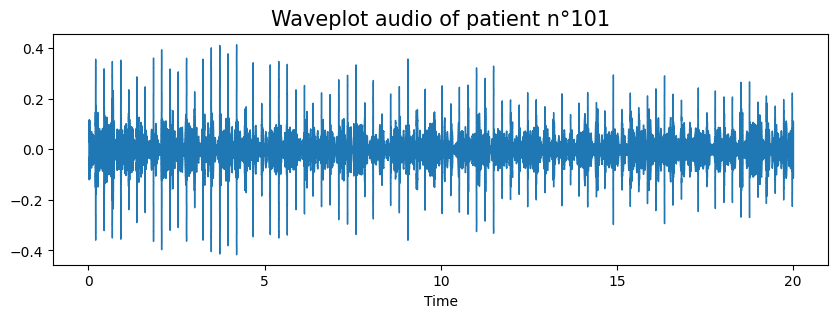

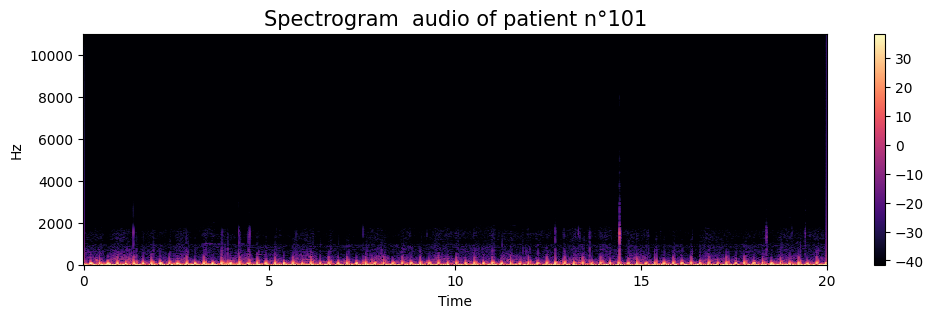

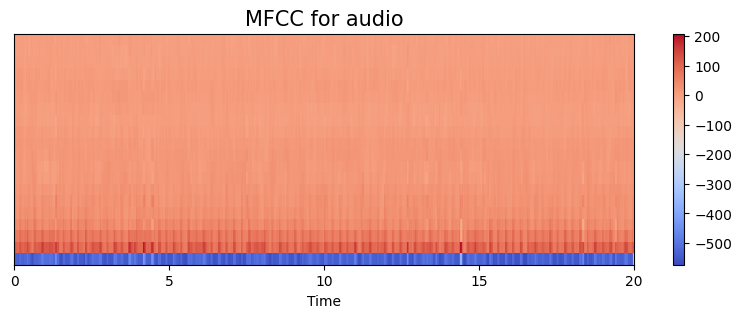

[ 2.11136429e-03  8.24872673e-01  8.15918446e-01  8.45891118e-01
  8.98937583e-01  9.21267688e-01  9.08841968e-01  8.65190446e-01
  8.47244203e-01  8.37308228e-01  8.49780202e-01  8.10206294e-01
  8.15435171e-01 -5.23849854e+02  1.11640640e+02  7.32082443e+01
  4.39450722e+01  3.20077477e+01  2.77491741e+01  2.16083717e+01
  1.49380188e+01  1.33324451e+01  1.54615126e+01  1.46483841e+01
  8.97555161e+00  4.43750191e+00  5.60549021e+00  9.13691235e+00
  9.68880081e+00  7.08604860e+00  4.66863966e+00  4.04591274e+00
  4.34850359e+00  6.83304891e-02  6.70803909e+01  3.51202850e+01
  8.64362907e+00  2.91632748e+00  9.89752650e-01  3.08465719e-01
  1.15872942e-01  5.39055020e-02  2.32306514e-02  2.07703728e-02
  1.19072199e-02  1.07585890e-02  8.29580892e-03  5.11436164e-03
  4.02030582e-03  2.41633016e-03  1.22594740e-03  8.97397113e-04
  8.73296987e-04  6.22790540e-04  4.21658158e-04  3.05508613e-04
  2.94449943e-04  2.72774720e-04  2.36629290e-04  2.13440042e-04
  1.82568314e-04  1.44749

In [ ]:
def extract_features(data, sample_rate):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr))

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) 

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) 

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) 
    
    return result

def get_features(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)
    
    # # data with noise
    # noise_data = noise(data)
    # res2 = extract_features(noise_data, sample_rate)
    # result = np.vstack((result, res2))
    
    # # data with stretching and pitching
    # new_data = stretch(data)
    # data_stretch_pitch = pitch(new_data, sample_rate)
    # res3 = extract_features(data_stretch_pitch, sample_rate)
    # result = np.vstack((result, res3))
    
    return result

print(get_features(show_audio()))
